# What Can Walker Do?

An exploration of my Oura ring data and an attempt to model some of my habits. There will be exploratory tool at the bottom so that you can take the reins and see what I would do in a given day. 

Take a peek and see what you would do if you were Walker for a day! (hint: it's mainly just to be bad at all tasks related to programming, reading and writing). 

In [1]:
import requests
import arrow
import pandas as pd
import statsmodels.formula.api as smf
import datetime
import seaborn as sns
import numpy as np

import psycopg2
from psycopg2 import extras

In [2]:
DB_SETTINGS = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'postgres',
    'port': 5432,
    'host': '127.0.0.1'
}

token = 'GJCC5LFS6LWUYLE2OJSAFUBI4H2W66UC'
headers = {'Authorization': f'Bearer {token}'}
base = 'https://api.ouraring.com'

#customize start and end date to your choosing
start = '2022-10-30'
end = arrow.now().format('YYYY-MM-DD')
params = {
    'start': start,
    'end': 'end',
}

In [3]:
sleep_peroid_api = f'{base}/v1/sleep'
sleep_data = requests.get(sleep_peroid_api, headers=headers, params=params)
sleep_data = sleep_data.json()

pd.DataFrame(sleep_data['sleep']).columns

Index(['summary_date', 'period_id', 'is_longest', 'timezone', 'bedtime_end',
       'bedtime_start', 'type', 'breath_average', 'average_breath_variation',
       'duration', 'total', 'awake', 'rem', 'deep', 'light', 'midpoint_time',
       'efficiency', 'restless', 'onset_latency', 'got_up_count',
       'wake_up_count', 'hr_5min', 'hr_average', 'hr_lowest',
       'lowest_heart_rate_time_offset', 'hypnogram_5min', 'rmssd',
       'rmssd_5min', 'score', 'score_alignment', 'score_deep',
       'score_disturbances', 'score_efficiency', 'score_latency', 'score_rem',
       'score_total', 'temperature_deviation', 'temperature_trend_deviation',
       'bedtime_start_delta', 'bedtime_end_delta', 'midpoint_at_delta',
       'temperature_delta'],
      dtype='object')

In [4]:
activity_peroid_api = f'{base}/v1/activity'
activity_data = requests.get(activity_peroid_api, headers=headers, params=params)
activity_data = activity_data.json()

In [5]:
sleep_df = (
    pd.DataFrame(sleep_data['sleep'])
    .set_index(['summary_date'])
    .rename(columns={'score': 'sleep_score', 'timezone': 'sleep_timezone', 'total': 'sleep_total', 'period_id': 'sleep_period_id'})
)
act_df = (
    pd.DataFrame(activity_data['activity'])
    .set_index(['summary_date'])
    .rename(columns={'score': 'activity_score', 'timezone': 'activity_timezone', 'total': 'activity_total', 'period_id': 'activity_period_id'})
)

In [6]:
#sleep_df.info()

In [7]:
#adding in a date sequence for sleep data
sleep_df['date'] = pd.date_range(start='10/30/2022', periods=len(sleep_df), freq='D')

sleep_df.head()

,sleep_period_id,is_longest,sleep_timezone,bedtime_end,bedtime_start,type,breath_average,average_breath_variation,duration,sleep_total,...,score_latency,score_rem,score_total,temperature_deviation,temperature_trend_deviation,bedtime_start_delta,bedtime_end_delta,midpoint_at_delta,temperature_delta,date
summary_date,,,,,,,,,,,,,,,,,,,,,
2022-10-30,3,1,-240,2022-10-31T02:33:09-04:00,2022-10-30T22:45:09-04:00,long_sleep,15.750,3.875,13680,11910,...,78,18,23,0.18,0.22,-4491,9189,2049,0.18,2022-10-30
2022-10-31,0,1,-240,2022-11-01T07:45:21-04:00,2022-10-31T21:41:21-04:00,long_sleep,15.375,2.875,36240,33210,...,81,98,100,-0.61,0.08,-8319,27921,9621,-0.61,2022-10-31
2022-11-01,0,1,-240,2022-11-02T08:02:49-04:00,2022-11-01T23:10:49-04:00,long_sleep,15.000,2.875,31920,28770,...,75,93,88,-0.38,-0.02,-2951,28969,12709,-0.38,2022-11-01
2022-11-02,0,1,-240,2022-11-03T08:18:03-04:00,2022-11-02T22:28:03-04:00,long_sleep,15.000,3.250,35400,30600,...,91,97,95,-0.40,0.01,-5517,29883,12213,-0.40,2022-11-02
2022-11-03,0,1,-240,2022-11-04T06:41:17-04:00,2022-11-03T22:40:17-04:00,long_sleep,15.125,2.625,28860,26670,...,83,86,79,-0.65,-0.10,-4783,24077,9407,-0.65,2022-11-03


In [11]:
act_df['date'] = pd.date_range(start='10/30/2022', periods=len(act_df), freq='D')
act_df.describe()

,activity_timezone,cal_active,cal_total,steps,daily_movement,non_wear,rest,inactive,low,medium,...,to_target_miles,activity_score,score_meet_daily_targets,score_move_every_hour,score_recovery_time,score_stay_active,score_training_frequency,score_training_volume,rest_mode_state,activity_total
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.00000,54.000000,54.000000,54.000000,54.000000,54.000000,54.0,54.000000
mean,-304.444444,730.000000,3062.000000,11643.685185,12380.314815,63.814815,508.370370,518.981481,241.870370,85.888889,...,-1.548825,89.351852,82.50000,96.611111,93.444444,77.703704,95.944444,98.074074,0.0,331.037037
std,36.583668,297.314839,337.931611,4275.542820,5145.707850,76.766265,86.819113,105.961811,58.155954,45.778246,...,3.411190,7.417871,22.50262,5.812857,14.837061,11.807624,12.946066,6.998253,0.0,88.243224
min,-360.000000,101.000000,2129.000000,1899.000000,1351.000000,0.000000,230.000000,162.000000,68.000000,2.000000,...,-9.755525,69.000000,25.00000,78.000000,13.000000,48.000000,40.000000,64.000000,0.0,77.000000
25%,-300.000000,575.750000,2884.750000,9968.500000,9897.500000,16.500000,470.500000,461.000000,225.250000,56.000000,...,-3.805897,85.500000,78.00000,95.000000,95.750000,71.250000,100.000000,100.000000,0.0,318.250000
50%,-300.000000,754.000000,3094.000000,11886.500000,12643.500000,41.000000,527.500000,513.000000,248.000000,85.500000,...,-1.584496,92.000000,95.00000,100.000000,100.000000,78.500000,100.000000,100.000000,0.0,342.500000
75%,-300.000000,885.750000,3255.500000,14065.250000,15305.000000,72.250000,568.500000,571.250000,277.250000,112.750000,...,0.776714,94.750000,100.00000,100.000000,100.000000,86.000000,100.000000,100.000000,0.0,377.000000
max,-240.000000,1435.000000,3826.000000,21443.000000,24358.000000,328.000000,629.000000,769.000000,346.000000,201.000000,...,6.586533,99.000000,100.00000,100.000000,100.000000,99.000000,100.000000,100.000000,0.0,538.000000


### Now that we have our data, let's start building a dashboard to explore:

In [12]:
import dash
from dash import html
from dash import dcc
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

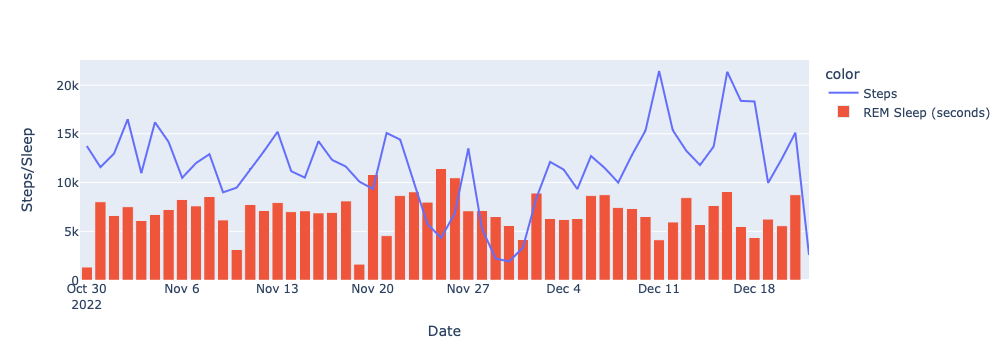

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [ ]:
import plotly.graph_objects as go # or plotly.express as px
fig = go.Figure() # or any Plotly Express function e.g. px.bar(...)
fig = px.line(x=act_df['date'], y=act_df['steps'], color=px.Constant("Steps"),
             labels=dict(x="Date", y="Steps/Sleep"))

fig.add_bar(x=sleep_df['date'], y=sleep_df['rem'], name="REM Sleep (seconds)")
fig.show()

import dash
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter